In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os

from importlib import reload

import small_utilities
reload(small_utilities)
import Block_analysis
reload(Block_analysis)

from Block_analysis import *
from small_utilities import *

import seaborn as sns

from scipy.stats import bootstrap


In [2]:
def reposition_first(array):
    if len(array.shape) == 2:  # Check if it's 2D
        # Reposition first row to the last
        return np.vstack((array[1:], array[0]))
    elif len(array.shape) == 3:  # Check if it's 3D
        # Reposition first slice to the last
        return np.concatenate((array[1:], array[:1]), axis=0)

import matplotlib.pyplot as plt
import numpy as np

def plot_colvar(colvar, trj_frames, num_cvs, labels, weights=None, out_dir=None):
    """
    Plot collective variables over time with corresponding histograms and reweighted histograms.

    Parameters:
        colvar (np.ndarray): Array of collective variables with time as the first column.
        trj_frames (dict): Dictionary mapping frame indices to frame times.
        num_cvs (int): Number of collective variables.
        labels (dict): Dictionary of labels for the collective variables.
        weights (np.ndarray, optional): Normalized weights for reweighting histograms. Must match the number of frames.
        out_dir (str, optional): Directory to save the plot. If None, the plot is shown but not saved.
    """
    # Configure subplots
    height_ratios = [1] * (num_cvs - 1)
    fig, axes = plt.subplots(
        num_cvs - 1, 2, figsize=(32, 40),
        gridspec_kw={
            'width_ratios': [4, 1],
            'height_ratios': height_ratios,
            'left': 0.1, 'right': 0.9,
            'bottom': 0.1, 'top': 0.9,
            'wspace': 0.02, 'hspace': 0.2
        },
        sharey=False,
        # sharex=True
    )

    # Check if weights are provided
    if weights is not None:
        if len(weights) != colvar.shape[0]:
            raise ValueError("Weights must match the number of frames in colvar.")
        weights = weights / np.sum(weights)  # Normalize weights

    # Loop over collective variables
    for i in range(num_cvs - 1):
        time = colvar.T[0] / 10**5  # Time in appropriate units
        data = colvar.T[i + 1]  # Data for the i-th collective variable

        # Line plot of collective variable over time
        axes[i, 0].plot(time, data, color='r', label=labels.get(str(i + 1), f'CV {i + 1}'))
        axes[i, 0].set_ylabel(labels.get(str(i + 1), f'CV {i + 1}'), size=35)
        axes[i, 0].set_xlabel(r"Time ($\mu$s)", size=35)
        axes[i, 0].tick_params(labelsize=25)
        xticks=[frame_time[1] / 10**5 for frame_idx, frame_time in trj_frames.items()]

        axes[i, 0].set_xticks(xticks)

        # Add vertical lines for trajectory frames
        for frame_idx, frame_time in trj_frames.items():
            axes[i, 0].axvline(x=frame_time[1] / 10**5, color='black', linewidth=3, linestyle='--')

        # Plot histogram
        axes[i, 1].hist(data, bins=50, orientation='horizontal', density=True, color='black', histtype='step', linewidth=2)

        # Plot reweighted histogram (if weights are provided)
        if weights is not None:
            # # Compute weighted histogram
            # hist, bin_edges = np.histogram(data, bins=50, density=True, weights=weights)
            # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            # axes[i, 1].plot(hist, bin_centers, color='green', linewidth=2, label='Reweighted')
            axes[i, 1].hist(data, bins=50, orientation='horizontal', density=True, color='green', histtype='step', linewidth=2, weights=weights)


        axes[i, 1].tick_params(labelsize=25)
        axes[i, 1].set_yticks([])

    # Save or display the plot
    if out_dir:
        plt.savefig(f"{out_dir}/cv_plot.png", dpi=310, bbox_inches='tight')
    else:
        plt.show()

def create_trj_frames(colvar_data, nreps=16):
    """
    Create trajectory frame intervals based on the given data.

    Parameters:
        colvar_data (list): A list or array-like structure containing the data.
        nreps (int): Number of intervals (default is 16).
        index (int): Index of the dataset to process (default is 100).

    Returns:
        dict: A dictionary where keys are strings of interval indices and values are lists of start and end points.
    """
    # Determine the total length and calculate interval size
    total_frames = colvar_data.shape[0] - 1
    interval_size = total_frames / nreps

    # Initialize variables
    a, b = 0, interval_size
    trj_frames = {}

    # Create intervals
    for i in range(nreps):
        trj_frames[str(i)] = [a, b]
        a = b
        b += interval_size

    return trj_frames

def bound_frac_kd_rw_(box_len,contact_matrix=[],weights=[]):

    def Kd_calc(bound, conc):
        return((1-bound)*conc/bound)
    
    Box_L = box_len
    # Convert nM to meters for Box_V in M^3
    Box_V = (Box_L*10**-9)**3
    # Convert Box_V to L
    Box_V_L = Box_V*1000
    #Concentraion in Mols/L
    Concentration = 1/(Box_V_L*(6.023*10**23))
    #print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)
    
    
    contact_rows = np.sum(contact_matrix, axis=1)
        
    if len(weights)>0 :
            
        c=np.where(contact_rows > 0, 1, 0)
            
        bf, bf_be = get_blockerror_pyblock_nanskip_rw_(c,weights)

        upper = bf+bf_be
        KD = Kd_calc(bf, Concentration)
        KD_upper = Kd_calc(upper, Concentration)
        KD_error = KD-KD_upper

        kd=np.round(KD*1000,4)
        kde=np.round(KD_error*1000,4)

        OUT=[bf, bf_be, kd, kde]
            
    else:
            
        bf, bf_be = get_blockerror_pyblock_nanskip(np.where(contact_rows > 0, 1, 0))# Re-weight this data

        upper = bf+bf_be
        KD = Kd_calc(bf, Concentration)
        KD_upper = Kd_calc(upper, Concentration)
        KD_error = KD-KD_upper

        kd=np.round(KD*1000,4)
        kde=np.round(KD_error*1000,4)

        OUT=[bf, bf_be, kd, kde]   
    
    return np.array(OUT)


In [3]:
index_dict={
    'Rg':1, 'H-bond':2, 'Helix-right':3, 'Betasheet':4, 'Helix-left':5, 'Polypro':6,
    'Dist-1':7, 'Dist-2':8, 'Dist-3':9, 'Dist-4':10, 'Dist-5':11, 'Dist-6':12
       }

## PBMeta-D protein+Fasudil (1)

In [4]:
PB_dir = '/home/jayakrishna/work/full_data_repo/PBMetaD/'
req_dir = 'fas_1'

colvar_data={}
weights_norm={}

for i in range(0,1000, 100):

    if i==0:
        colvar_data[i+1000]=np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat', comments=['#','@'])
        num_cvs, _, weights_norm[i+1000] = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat')
        print(f"Sum of combined xtc weights : {np.sum(weights_norm[i+1000])}")
        print(f"Number of frames : {colvar_data[i+1000].shape[0]}")
    else:
            
        colvar_data[i]=np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat', comments=['#','@'])
        num_cvs, _, weights_norm[i] = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat')

        print(f"Sum of combined xtc weights : {np.sum(weights_norm[i])}")
        print(f"Number of frames : {colvar_data[i].shape[0]}")
    


Sum of combined xtc weights : 1.0
Number of frames : 1600001
Sum of combined xtc weights : 0.9999999999999998
Number of frames : 160001
Sum of combined xtc weights : 0.9999999999999999
Number of frames : 320001
Sum of combined xtc weights : 1.0
Number of frames : 480001
Sum of combined xtc weights : 0.9999999999999999
Number of frames : 640001
Sum of combined xtc weights : 1.0000000000000004
Number of frames : 800001
Sum of combined xtc weights : 0.9999999999999993
Number of frames : 960001
Sum of combined xtc weights : 1.0
Number of frames : 1120001
Sum of combined xtc weights : 0.9999999999999998
Number of frames : 1280001
Sum of combined xtc weights : 1.0000000000000004
Number of frames : 1440001


In [13]:
file_name = 'contact_matrix.json'
cm = {}
l_c={}

for i in range(0,1000, 100):

    if i==0:
        cm[i+1000]=load_json(f'{PB_dir}/{req_dir}/data/out_{i}/{file_name}')
        l_c[i+1000] = np.sum(cm[i+1000]['0'], 1)

    else:
            
        cm[i]=load_json(f'{PB_dir}/{req_dir}/data/out_{i}/{file_name}')
        l_c[i] = np.sum(cm[i]['0'], 1)



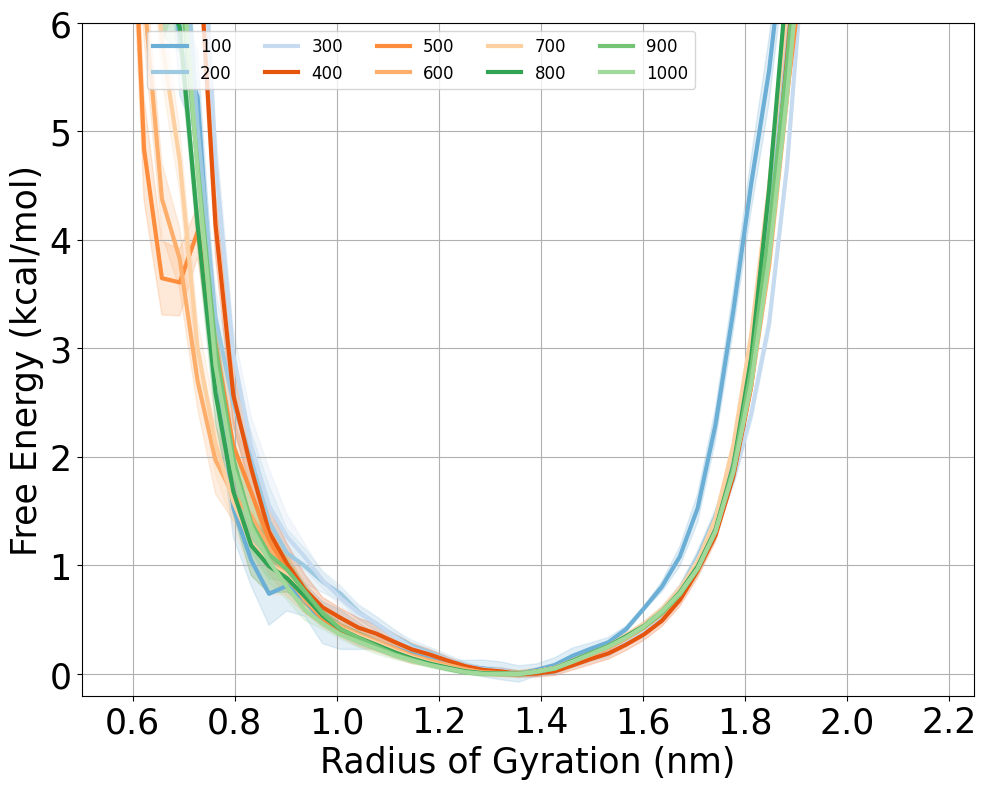

In [25]:
np.seterr(invalid='ignore')

plt.figure(figsize=(10,8))

for i in range(100,1100, 100):
    dG1, bin_centers, ferr = free_energy_1D_blockerror(colvar_data[i].T[index_dict['Rg']], T=300, x0=0.5, xmax=2.25, bins=50, blocks=5, weights=weights_norm[i])

    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

plt.ylim(-0.2, 6)
plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()

In [8]:
import mdtraj as md

xtc='/home/jayakrishna/work/full_data_repo/PBMetaD/fas_1/xtc/pbc_0.xtc'
pdb='/home/jayakrishna/work/full_data_repo/PBMetaD/prot_fas.pdb'

traj=md.load_xtc(xtc, pdb, stride=40000)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.429000377655029 nm


In [12]:
for i in range(100,1100, 100):
    kd_bf_data=bound_frac_kd_rw_(box_len,cm[i]['0'])

    print(f"Time ==> {(i*16)/1000} microsec; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")


Time ==> 1.6 microsec; BF ==> 0.4016; BF_err ==> 0.0360
Time ==> 3.2 microsec; BF ==> 0.3977; BF_err ==> 0.0323
Time ==> 4.8 microsec; BF ==> 0.3894; BF_err ==> 0.0235
Time ==> 6.4 microsec; BF ==> 0.3890; BF_err ==> 0.0245
Time ==> 8.0 microsec; BF ==> 0.3878; BF_err ==> 0.0199
Time ==> 9.6 microsec; BF ==> 0.3888; BF_err ==> 0.0192
Time ==> 11.2 microsec; BF ==> 0.3877; BF_err ==> 0.0163
Time ==> 12.8 microsec; BF ==> 0.3833; BF_err ==> 0.0177
Time ==> 14.4 microsec; BF ==> 0.3739; BF_err ==> 0.0156
Time ==> 16.0 microsec; BF ==> 0.3813; BF_err ==> 0.0152


In [26]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))
index=0

for rg_t, lc_t in zip(colvar_data[1000].T[index_dict['Rg']], l_c[1000]):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(bf_zone, weights=weights_norm[1000])}")
# print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")


Prob, err : (0.00032324702691885, 0.00020713362094988341)


In [29]:
lc_zone_1=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))

for i in np.where(l_c[1000]>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(lc_zone_1, weights=weights_norm[1000])}")

lc_zone_2=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))

for i in np.where(l_c[1000]<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(lc_zone_2, weights=weights_norm[1000])}")

Prob, err : (0.0011337590998208194, 0.0005532704807858005)
Prob, err : (0.9988662409001787, 0.0005532704807858)


In [45]:
# cm_zone_1=[]
# w1=[]

# for i in np.where(l_c[1000]>=12)[0] : cm_zone_1.append(cm[1000]['0'][i]) ; w1.append(weights_norm[1000][i])
cm_zone_1 = [cm[1000]['0'][i] for i in np.where(l_c[1000]>=12)[0]]
w1 = [weights_norm[1000][i] for i in np.where(l_c[1000]>=12)[0]]

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1, weights=np.array(w1))[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1, weights=np.array(w1))[1]}")

# cm_zone_2=[]
# w2=[]

cm_zone_2 = [cm[1000]['0'][i] for i in np.where(l_c[1000]<12)[0]]
w2 = [weights_norm[1000][i] for i in np.where(l_c[1000]<12)[0]]

# for i in np.where(l_c[1000]<12)[0] : cm_zone_2.append(cm[1000]['0'][i]) ; w2.append(weights_norm[1000][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2, weights=np.array(w2))[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2, weights=np.array(w2))[1]}")

/home/jayakrishna/softwares/miniconda3/envs/myenv/lib/python3.11/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in scalar divide
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:


Prob, err : 0.0011337590998208192, 0.0
Prob, err : 0.4401130045902842, 0.01519677225127863


## PBMeta-D protein+Fasudil (2)

In [46]:
PB_dir = '/home/jayakrishna/work/full_data_repo/PBMetaD/'
req_dir = 'fas_2'

colvar_data={}
weights_norm={}

for i in range(0,1000, 100):

    if i==0:
        colvar_data[i+1000]=np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat', comments=['#','@'])
        num_cvs, _, weights_norm[i+1000] = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat')
        print(f"Sum of combined xtc weights : {np.sum(weights_norm[i+1000])}")
        print(f"Number of frames : {colvar_data[i+1000].shape[0]}")
    else:
            
        colvar_data[i]=np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat', comments=['#','@'])
        num_cvs, _, weights_norm[i] = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat')

        print(f"Sum of combined xtc weights : {np.sum(weights_norm[i])}")
        print(f"Number of frames : {colvar_data[i].shape[0]}")
    


Sum of combined xtc weights : 1.0000000000000004
Number of frames : 1600001
Sum of combined xtc weights : 0.9999999999999997
Number of frames : 160001
Sum of combined xtc weights : 0.9999999999999996
Number of frames : 320001
Sum of combined xtc weights : 1.0000000000000004
Number of frames : 480001
Sum of combined xtc weights : 1.0
Number of frames : 640001
Sum of combined xtc weights : 0.9999999999999997
Number of frames : 800001
Sum of combined xtc weights : 1.0000000000000004
Number of frames : 960001
Sum of combined xtc weights : 0.9999999999999997
Number of frames : 1120001
Sum of combined xtc weights : 1.0
Number of frames : 1280001
Sum of combined xtc weights : 1.0000000000000007
Number of frames : 1440001


In [47]:
file_name = 'contact_matrix.json'
cm = {}
l_c={}

for i in range(0,1000, 100):

    if i==0:
        cm[i+1000]=load_json(f'{PB_dir}/{req_dir}/data/out_{i}/{file_name}')
        l_c[i+1000] = np.sum(cm[i+1000]['0'], 1)

    else:
            
        cm[i]=load_json(f'{PB_dir}/{req_dir}/data/out_{i}/{file_name}')
        l_c[i] = np.sum(cm[i]['0'], 1)



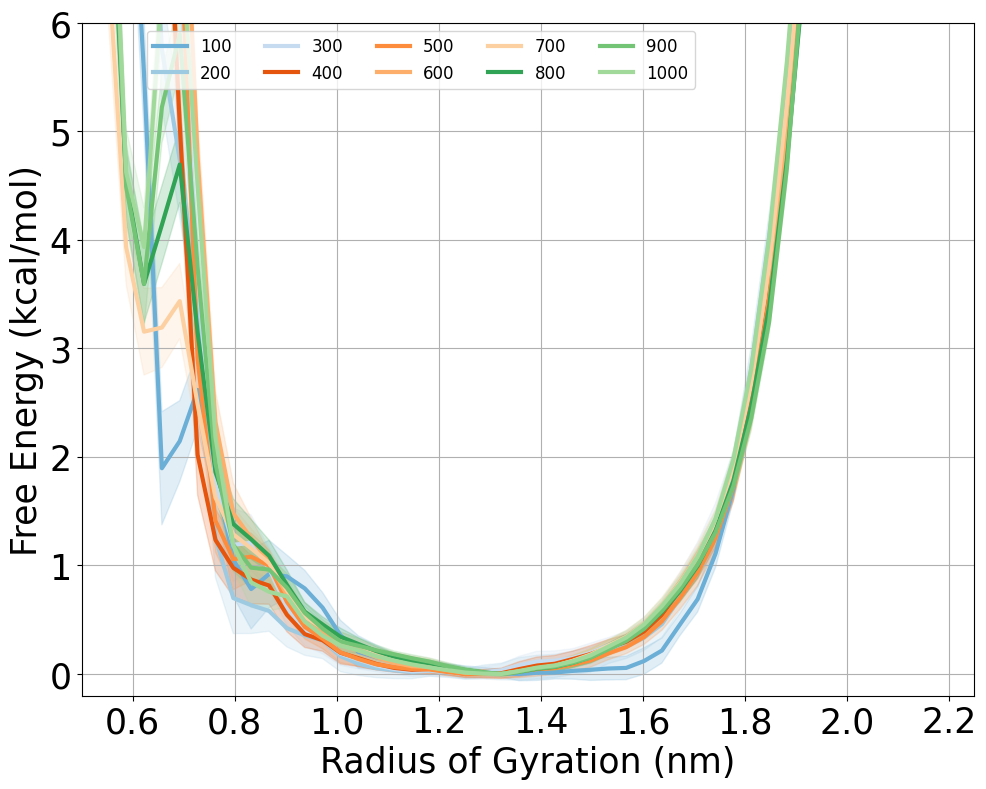

In [48]:
np.seterr(invalid='ignore')

plt.figure(figsize=(10,8))

for i in range(100,1100, 100):
    dG1, bin_centers, ferr = free_energy_1D_blockerror(colvar_data[i].T[index_dict['Rg']], T=300, x0=0.5, xmax=2.25, bins=50, blocks=5, weights=weights_norm[i])

    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

plt.ylim(-0.2, 6)
plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()

In [50]:
import mdtraj as md

xtc='/home/jayakrishna/work/full_data_repo/PBMetaD/fas_2/xtc/pbc_0.xtc'
pdb='/home/jayakrishna/work/full_data_repo/PBMetaD/prot_fas_1.pdb'

traj=md.load_xtc(xtc, pdb, stride=40000)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.429000377655029 nm


In [51]:
for i in range(100,1100, 100):
    kd_bf_data=bound_frac_kd_rw_(box_len,cm[i]['0'])

    print(f"Time ==> {(i*16)/1000} microsec; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")


Time ==> 1.6 microsec; BF ==> 0.3955; BF_err ==> 0.0607
Time ==> 3.2 microsec; BF ==> 0.3789; BF_err ==> 0.0386
Time ==> 4.8 microsec; BF ==> 0.3804; BF_err ==> 0.0321
Time ==> 6.4 microsec; BF ==> 0.3799; BF_err ==> 0.0229
Time ==> 8.0 microsec; BF ==> 0.3780; BF_err ==> 0.0258
Time ==> 9.6 microsec; BF ==> 0.3905; BF_err ==> 0.0186
Time ==> 11.2 microsec; BF ==> 0.3914; BF_err ==> 0.0207
Time ==> 12.8 microsec; BF ==> 0.3881; BF_err ==> 0.0180
Time ==> 14.4 microsec; BF ==> 0.3948; BF_err ==> 0.0222
Time ==> 16.0 microsec; BF ==> 0.3874; BF_err ==> 0.0162


In [52]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))
index=0

for rg_t, lc_t in zip(colvar_data[1000].T[index_dict['Rg']], l_c[1000]):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(bf_zone, weights=weights_norm[1000])}")
# print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")


Prob, err : (0.002505477211159842, 0.0015426870244605246)


In [53]:
lc_zone_1=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))

for i in np.where(l_c[1000]>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(lc_zone_1, weights=weights_norm[1000])}")

lc_zone_2=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))

for i in np.where(l_c[1000]<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(lc_zone_2, weights=weights_norm[1000])}")

Prob, err : (0.005670639420318212, 0.0028524760955895697)
Prob, err : (0.9943293605796816, 0.0028524760955895684)


In [54]:
# cm_zone_1=[]
# w1=[]

# for i in np.where(l_c[1000]>=12)[0] : cm_zone_1.append(cm[1000]['0'][i]) ; w1.append(weights_norm[1000][i])
cm_zone_1 = [cm[1000]['0'][i] for i in np.where(l_c[1000]>=12)[0]]
w1 = [weights_norm[1000][i] for i in np.where(l_c[1000]>=12)[0]]

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1, weights=np.array(w1))[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1, weights=np.array(w1))[1]}")

# cm_zone_2=[]
# w2=[]

cm_zone_2 = [cm[1000]['0'][i] for i in np.where(l_c[1000]<12)[0]]
w2 = [weights_norm[1000][i] for i in np.where(l_c[1000]<12)[0]]

# for i in np.where(l_c[1000]<12)[0] : cm_zone_2.append(cm[1000]['0'][i]) ; w2.append(weights_norm[1000][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2, weights=np.array(w2))[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2, weights=np.array(w2))[1]}")

Prob, err : 0.005670639420318212, 0.0
Prob, err : 0.41275515761258447, 0.01754707588791668


## PBMeta-D protein+Ligand 47 (1)

In [56]:
PB_dir = '/home/jayakrishna/work/full_data_repo/PBMetaD/'
req_dir = 'lig47_1'

colvar_data={}
weights_norm={}

for i in range(0,1000, 100):

    if i==0:
        colvar_data[i+1000]=np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat', comments=['#','@'])
        num_cvs, _, weights_norm[i+1000] = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat')
        print(f"Sum of combined xtc weights : {np.sum(weights_norm[i+1000])}")
        print(f"Number of frames : {colvar_data[i+1000].shape[0]}")
    else:
            
        colvar_data[i]=np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat', comments=['#','@'])
        num_cvs, _, weights_norm[i] = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat')

        print(f"Sum of combined xtc weights : {np.sum(weights_norm[i])}")
        print(f"Number of frames : {colvar_data[i].shape[0]}")
    


Sum of combined xtc weights : 1.0000000000000007
Number of frames : 1600001
Sum of combined xtc weights : 1.0
Number of frames : 160001
Sum of combined xtc weights : 1.0
Number of frames : 320001
Sum of combined xtc weights : 0.9999999999999998
Number of frames : 480001
Sum of combined xtc weights : 1.0
Number of frames : 640001
Sum of combined xtc weights : 1.0000000000000009
Number of frames : 800001
Sum of combined xtc weights : 0.9999999999999991
Number of frames : 960001
Sum of combined xtc weights : 0.9999999999999991
Number of frames : 1120001
Sum of combined xtc weights : 1.0000000000000002
Number of frames : 1280001
Sum of combined xtc weights : 0.9999999999999999
Number of frames : 1440001


In [57]:
file_name = 'contact_matrix.json'
cm = {}
l_c={}

for i in range(0,1000, 100):

    if i==0:
        cm[i+1000]=load_json(f'{PB_dir}/{req_dir}/data/out_{i}/{file_name}')
        l_c[i+1000] = np.sum(cm[i+1000]['0'], 1)

    else:
            
        cm[i]=load_json(f'{PB_dir}/{req_dir}/data/out_{i}/{file_name}')
        l_c[i] = np.sum(cm[i]['0'], 1)



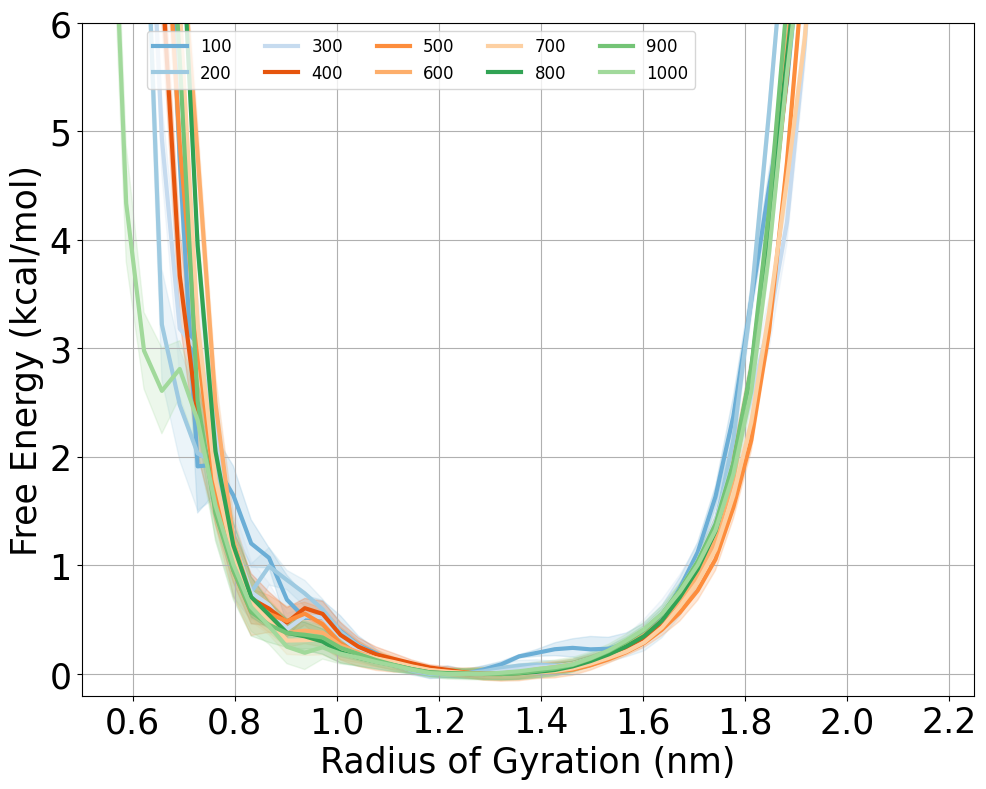

In [58]:
np.seterr(invalid='ignore')

plt.figure(figsize=(10,8))

for i in range(100,1100, 100):
    dG1, bin_centers, ferr = free_energy_1D_blockerror(colvar_data[i].T[index_dict['Rg']], T=300, x0=0.5, xmax=2.25, bins=50, blocks=5, weights=weights_norm[i])

    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

plt.ylim(-0.2, 6)
plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()

In [59]:
import mdtraj as md

xtc='/home/jayakrishna/work/full_data_repo/PBMetaD/lig47_1/xtc/pbc_0.xtc'
pdb='/home/jayakrishna/work/full_data_repo/PBMetaD/prot_lig47_1.pdb'

traj=md.load_xtc(xtc, pdb, stride=40000)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.428399562835693 nm


In [60]:
for i in range(100,1100, 100):
    kd_bf_data=bound_frac_kd_rw_(box_len,cm[i]['0'])

    print(f"Time ==> {(i*16)/1000} microsec; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")


Time ==> 1.6 microsec; BF ==> 0.4260; BF_err ==> 0.0615
Time ==> 3.2 microsec; BF ==> 0.4316; BF_err ==> 0.0431
Time ==> 4.8 microsec; BF ==> 0.4236; BF_err ==> 0.0339
Time ==> 6.4 microsec; BF ==> 0.4140; BF_err ==> 0.0281
Time ==> 8.0 microsec; BF ==> 0.4280; BF_err ==> 0.0327
Time ==> 9.6 microsec; BF ==> 0.4298; BF_err ==> 0.0280
Time ==> 11.2 microsec; BF ==> 0.4253; BF_err ==> 0.0275
Time ==> 12.8 microsec; BF ==> 0.4227; BF_err ==> 0.0238
Time ==> 14.4 microsec; BF ==> 0.4209; BF_err ==> 0.0220
Time ==> 16.0 microsec; BF ==> 0.4275; BF_err ==> 0.0219


In [61]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))
index=0

for rg_t, lc_t in zip(colvar_data[1000].T[index_dict['Rg']], l_c[1000]):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(bf_zone, weights=weights_norm[1000])}")
# print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")


Prob, err : (0.0008113263071742713, 0.0006125782481713263)


In [62]:
lc_zone_1=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))

for i in np.where(l_c[1000]>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(lc_zone_1, weights=weights_norm[1000])}")

lc_zone_2=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))

for i in np.where(l_c[1000]<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(lc_zone_2, weights=weights_norm[1000])}")

Prob, err : (0.003223668888096386, 0.0016290122360522548)
Prob, err : (0.9967763311119038, 0.0016290122360522541)


In [63]:
# cm_zone_1=[]
# w1=[]

# for i in np.where(l_c[1000]>=12)[0] : cm_zone_1.append(cm[1000]['0'][i]) ; w1.append(weights_norm[1000][i])
cm_zone_1 = [cm[1000]['0'][i] for i in np.where(l_c[1000]>=12)[0]]
w1 = [weights_norm[1000][i] for i in np.where(l_c[1000]>=12)[0]]

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1, weights=np.array(w1))[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1, weights=np.array(w1))[1]}")

# cm_zone_2=[]
# w2=[]

cm_zone_2 = [cm[1000]['0'][i] for i in np.where(l_c[1000]<12)[0]]
w2 = [weights_norm[1000][i] for i in np.where(l_c[1000]<12)[0]]

# for i in np.where(l_c[1000]<12)[0] : cm_zone_2.append(cm[1000]['0'][i]) ; w2.append(weights_norm[1000][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2, weights=np.array(w2))[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2, weights=np.array(w2))[1]}")

Prob, err : 0.003223668888096386, 0.0
Prob, err : 0.5323819535360067, 0.021383235541146847


## PBMeta-D protein+Ligand 47 (2)

In [64]:
PB_dir = '/home/jayakrishna/work/full_data_repo/PBMetaD/'
req_dir = 'lig47_2'

colvar_data={}
weights_norm={}

for i in range(0,1000, 100):

    if i==0:
        colvar_data[i+1000]=np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat', comments=['#','@'])
        num_cvs, _, weights_norm[i+1000] = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat')
        print(f"Sum of combined xtc weights : {np.sum(weights_norm[i+1000])}")
        print(f"Number of frames : {colvar_data[i+1000].shape[0]}")
    else:
            
        colvar_data[i]=np.loadtxt(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat', comments=['#','@'])
        num_cvs, _, weights_norm[i] = norm_weights(f'{PB_dir}/{req_dir}/colvar/colvar_{i}.dat')

        print(f"Sum of combined xtc weights : {np.sum(weights_norm[i])}")
        print(f"Number of frames : {colvar_data[i].shape[0]}")
    


Sum of combined xtc weights : 0.9999999999999999
Number of frames : 1600001
Sum of combined xtc weights : 1.0
Number of frames : 160001
Sum of combined xtc weights : 1.0000000000000007
Number of frames : 320001
Sum of combined xtc weights : 1.0
Number of frames : 480001
Sum of combined xtc weights : 0.9999999999999994
Number of frames : 640001
Sum of combined xtc weights : 1.0000000000000038
Number of frames : 800001
Sum of combined xtc weights : 0.9999999999999999
Number of frames : 960001
Sum of combined xtc weights : 1.0000000000000029
Number of frames : 1120001
Sum of combined xtc weights : 0.9999999999999991
Number of frames : 1280001
Sum of combined xtc weights : 0.9999999999999998
Number of frames : 1440001


In [65]:
file_name = 'contact_matrix.json'
cm = {}
l_c={}

for i in range(0,1000, 100):

    if i==0:
        cm[i+1000]=load_json(f'{PB_dir}/{req_dir}/data/out_{i}/{file_name}')
        l_c[i+1000] = np.sum(cm[i+1000]['0'], 1)

    else:
            
        cm[i]=load_json(f'{PB_dir}/{req_dir}/data/out_{i}/{file_name}')
        l_c[i] = np.sum(cm[i]['0'], 1)



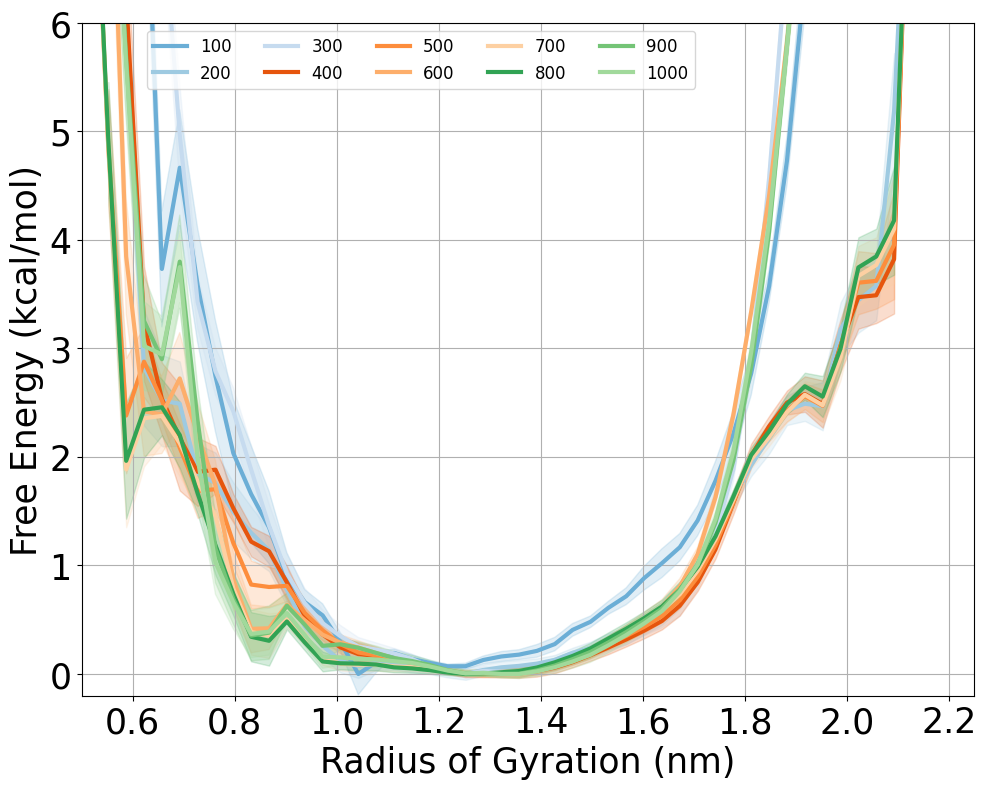

In [66]:
np.seterr(invalid='ignore')

plt.figure(figsize=(10,8))

for i in range(100,1100, 100):
    dG1, bin_centers, ferr = free_energy_1D_blockerror(colvar_data[i].T[index_dict['Rg']], T=300, x0=0.5, xmax=2.25, bins=50, blocks=5, weights=weights_norm[i])

    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

plt.ylim(-0.2, 6)
plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()

In [67]:
import mdtraj as md

xtc='/home/jayakrishna/work/full_data_repo/PBMetaD/lig47_2/xtc/pbc_0.xtc'
pdb='/home/jayakrishna/work/full_data_repo/PBMetaD/prot_lig47_2.pdb'

traj=md.load_xtc(xtc, pdb, stride=40000)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.428399562835693 nm


In [68]:
for i in range(100,1100, 100):
    kd_bf_data=bound_frac_kd_rw_(box_len,cm[i]['0'])

    print(f"Time ==> {(i*16)/1000} microsec; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")


Time ==> 1.6 microsec; BF ==> 0.4308; BF_err ==> 0.0711
Time ==> 3.2 microsec; BF ==> 0.4454; BF_err ==> 0.0431
Time ==> 4.8 microsec; BF ==> 0.4488; BF_err ==> 0.0387
Time ==> 6.4 microsec; BF ==> 0.4441; BF_err ==> 0.0271
Time ==> 8.0 microsec; BF ==> 0.4453; BF_err ==> 0.0230
Time ==> 9.6 microsec; BF ==> 0.4348; BF_err ==> 0.0216
Time ==> 11.2 microsec; BF ==> 0.4377; BF_err ==> 0.0227
Time ==> 12.8 microsec; BF ==> 0.4293; BF_err ==> 0.0209
Time ==> 14.4 microsec; BF ==> 0.4207; BF_err ==> 0.0207
Time ==> 16.0 microsec; BF ==> 0.4258; BF_err ==> 0.0188


In [69]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))
index=0

for rg_t, lc_t in zip(colvar_data[1000].T[index_dict['Rg']], l_c[1000]):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(bf_zone, weights=weights_norm[1000])}")
# print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")


Prob, err : (0.005879456821262534, 0.002720794530546031)


In [70]:
lc_zone_1=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))

for i in np.where(l_c[1000]>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(lc_zone_1, weights=weights_norm[1000])}")

lc_zone_2=np.zeros(len(colvar_data[1000].T[index_dict['Rg']]))

for i in np.where(l_c[1000]<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip_rw_(lc_zone_2, weights=weights_norm[1000])}")

Prob, err : (0.011012620776784355, 0.0037829689459745815)
Prob, err : (0.9889873792232154, 0.003782968945974579)


In [71]:
# cm_zone_1=[]
# w1=[]

# for i in np.where(l_c[1000]>=12)[0] : cm_zone_1.append(cm[1000]['0'][i]) ; w1.append(weights_norm[1000][i])
cm_zone_1 = [cm[1000]['0'][i] for i in np.where(l_c[1000]>=12)[0]]
w1 = [weights_norm[1000][i] for i in np.where(l_c[1000]>=12)[0]]

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1, weights=np.array(w1))[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1, weights=np.array(w1))[1]}")

# cm_zone_2=[]
# w2=[]

cm_zone_2 = [cm[1000]['0'][i] for i in np.where(l_c[1000]<12)[0]]
w2 = [weights_norm[1000][i] for i in np.where(l_c[1000]<12)[0]]

# for i in np.where(l_c[1000]<12)[0] : cm_zone_2.append(cm[1000]['0'][i]) ; w2.append(weights_norm[1000][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2, weights=np.array(w2))[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2, weights=np.array(w2))[1]}")

Prob, err : 0.011012620776784356, 0.0
Prob, err : 0.4965036460684882, 0.018907202266894466
